# Time Series Forecasting

In [1]:
# Libraries for anaysis anf machine learning
import pandas as pd
import numpy as np
from math import sqrt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Training data
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv',
                    parse_dates=['date'],
                    infer_datetime_format=True,
                    usecols=lambda column: column not in ['id'])

# Testing data
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv',
                   parse_dates=['date'],
                   infer_datetime_format=True,
                   usecols=lambda column: column not in ['id'])

# Sample submission data
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')

**train.csv** - the training set, which includes the sales data for each date-country-store-item combination.  
**test.csv** - the test set; your task is to predict the corresponding item sales for each date-country-store-item combination.

In [3]:
# Unstacking the categorical columns to prepare taget variables
cat_cols = ['date','country','store','product']
train = train.groupby(cat_cols).sum().unstack([-3,-2,-1])
test = test.groupby(cat_cols).sum().unstack([-3,-2,-1])

In [4]:
# Features(date)
x = train.index.to_frame()
x.index = x.date.dt.to_period("D")
# Targets(sales for all the categories)
y = train

We will use hybrid model so we have to make trend features for the linear model(Linear Regression) and other complex features for the non-linear model(XGBoost)

In [5]:
# Using deterministic process from the statsmodels library to create trend features
dp_trend = DeterministicProcess(index=x.index,
                                order=1,
                                drop=True)
x_t = dp_trend.in_sample()
test_t = dp_trend.out_of_sample(test.shape[0])

In [6]:
# Using dererministic process fromthe statsmodels library to make seasonal features(indicatores and fourier features)
fourier = CalendarFourier(freq='M', order=4)
dp_seasonality = DeterministicProcess(index=x.index,
                                      constant = True,
                                      seasonal=True,
                                      additional_terms=[fourier],
                                      drop=True)
x_s = dp_seasonality.in_sample()
test_s = dp_seasonality.out_of_sample(test.shape[0])

In [7]:
# Creating a funtion to create some other time series features
def time_series_features(data):
    data['dayofyear'] = data.index.dayofyear
    data['weekofyear'] = data.index.weekofyear

    # Use to_period('D') for year and month boundaries (compatible with older Pandas)
    data['isyearstart'] = data.index.to_timestamp().is_year_start.astype('int')
    data['isyearend'] = data.index.to_timestamp().is_year_end.astype('int')
    data['ismonthstart'] = data.index.to_timestamp().is_month_start.astype('int')
    data['ismonthend'] = data.index.to_timestamp().is_month_end.astype('int')
    # Create a binary column for weekends
    data['isweekend'] = (data.index.weekday > 4).astype(int)

    data['dayofmonth'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['quarterofyear'] = data.index.quarter
    return data
x_s = time_series_features(x_s)
test_s = time_series_features(test_s)

In [8]:
# As we saw in our analysis notebook there was s decline in sales from march 2020 to july 2020 due to covid so making a binary feature
# to represent that decline(1 for the covid period and 0 for the remaining time)
def lockdown(df, lockdown_start, lockdown_end):
    df['lockdown'] = ((df.index >= lockdown_start) & (df.index <= lockdown_end)).astype(int)

lockdown_start = '2020-3-1'
lockdown_end = '2020-7-1'    
lockdown(x_s, lockdown_start, lockdown_end)
lockdown(test_s, lockdown_start, lockdown_end)

In [9]:
# Before making forecast on the test dataset we will make validation data to evaluate the performace of our model
# We will use 4 year of data to train the model and make forecast on the next 1 year
split_date = '2020-12-31'
y_train, y_val = y[: split_date], y[split_date :]
x_t_train, x_t_val = x_t[: split_date], x_t[split_date :]
x_s_train, x_s_val = x_s[: split_date], x_s[split_date :]

In [10]:
# Now making a simple class for hybrid model
class HybridModel(BaseEstimator, RegressorMixin):
    # Creating the class initializer
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.columns = None
        
    # Creating the fit function for the hybrid model class
    def fit(self, x_t_train, x_s_train, y_train):
        self.model_1.fit(x_t_train, y_train)
        
        y_fit = pd.DataFrame(self.model_1.predict(x_t_train),
                             index=y_train.index,
                             columns=y_train.columns) 
        
        y_resid = y_train - y_fit
        self.model_2.fit(x_s_train, y_resid)
        
        self.columns = y_train.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
    
    # Creating the predict function for the hybrid model class
    def predict(self, x_t_val, x_s_val):
        y_pred = pd.DataFrame(self.model_1.predict(x_t_val), 
                              index=x_t_val.index, 
                              columns=self.columns)
        y_pred += self.model_2.predict(x_s_val)
        return y_pred

I used GridSearchCv to get these hyper parameters(didn't included that code because of too much clutter)  
{max_depth: 4  
subsample: 0.8  
colsample_bytree: 0.8  
eta: 0.01
n_estimators: 150  
gamma: 0.2  
lamda: 0.1  
alpha: 0.1}


In [11]:
# Tunned them further on my experience
params = {'colsample_bytree': 1, 'gamma': 0.1, 'eta': 0.007, 'max_depth': 7, 'n_estimators': 160, 'alpha': 0.01, 'lambda': 0.01, 'subsample': 0.9}
# Defining the models
hybrid_model = HybridModel(
    model_1=LinearRegression(fit_intercept=True),
    model_2=XGBRegressor(**params))

In [12]:
# training the model on the training data
hybrid_model.fit(x_t_train, x_s_train, y_train)

0.08170816478150564
0.2899924657345678


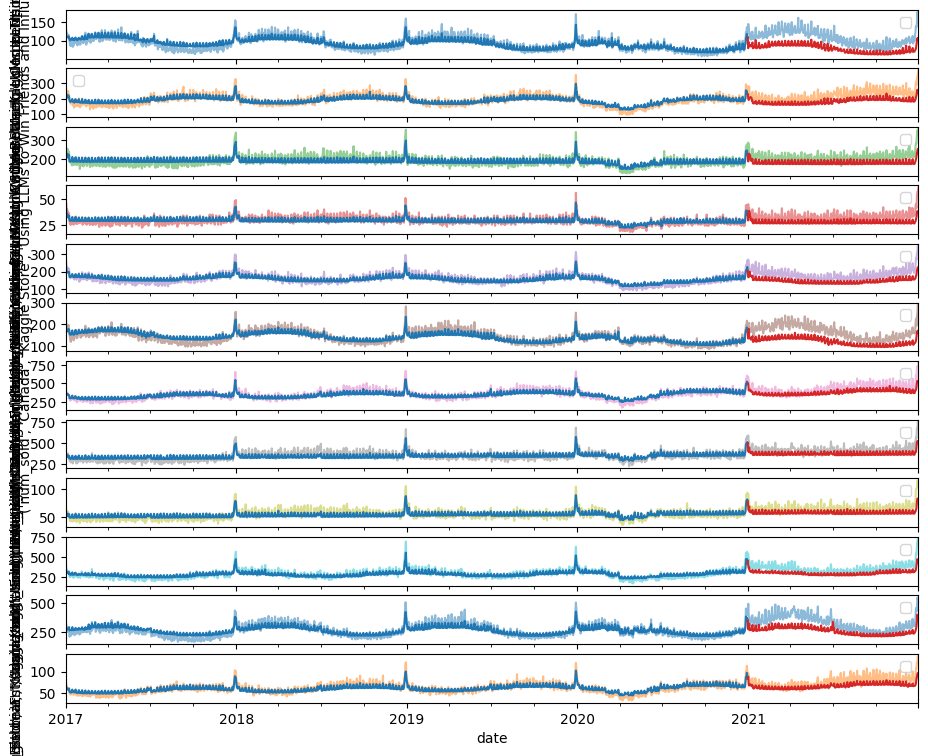

In [13]:
# Fitting the model on the training data and making the forecast on the validation data
y_fit = hybrid_model.predict(x_t_train, x_s_train)
y_pred = hybrid_model.predict(x_t_val, x_s_val)

# Calculation the mean_squared_log_error(lower is better)
rmle_fit = sqrt(mean_squared_log_error(y_train, y_fit))
rmle_pred = sqrt(mean_squared_log_error(y_val, y_pred))
print(rmle_fit)
print(rmle_pred)

# Now lets visualize the prediction for 12 categories
families = y.columns[24:36]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

MSLE seems good and visualization of forecast also looks great. I tried many hyperparameter and this was the best I got. I you have any suggestion tell me in the comment section below.I will appriciate it!

In [14]:
# Now training the model on the whole dataset
hybrid_model.fit(x_t,x_s,y)

In [15]:
# Making predictions on the test dataset
submit = hybrid_model.predict(test_t, test_s)

# Making data ready for submission
submit = submit.stack(['country','store','product']).reset_index()
# Creating the id column in the dataset as required for submission
submit['id'] = np.arange(start=sample_submission.id.iloc[0], stop=len(submit)+sample_submission.id.iloc[0])
submit = submit[['id','num_sold']]
submit.set_index('id', inplace=True)
submit.to_csv('time_series_forecasting_for_kaggle_store.csv')

In [16]:
submit

,num_sold
id,
136950,211.039013
136951,199.283833
136952,24.240483
136953,222.294601
136954,155.953887
...,...
164320,177.859058
164321,158.772881
164322,26.592675


Thanks for sticking with me for this long.

give it a thumbs up👍 if you found it useful.

Untill next tiem Kagglers!